Import Libraries and Setup

In [95]:
# Import necessary libraries
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Set visualization style for clean plotting
plt.style.use('ggplot')

# Ensure all columns and rows are visible for large datasets
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


Load and Normalize the Music Dataset

In [96]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the Spotify dataset
from google.colab import drive
drive.mount('/content/drive')
spotify_dataset = pd.read_csv('/content/drive/MyDrive/dataset.csv')

# Drop duplicates and missing values
spotify_dataset = spotify_dataset.drop_duplicates()
spotify_dataset = spotify_dataset.dropna()

# Select relevant features for clustering
selected_features = spotify_dataset[["energy", "danceability", "valence", "tempo", "popularity", "acousticness", "loudness"]]

# Normalize the selected features
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(selected_features)

# Create a normalized DataFrame
normalized_spotify_dataset = pd.DataFrame(normalized_features, columns=["energy", "danceability", "valence", "tempo", "popularity", "acousticness", "loudness"])

# Add track_id to maintain track identity
normalized_spotify_dataset["track_id"] = spotify_dataset["track_id"]

# Display the normalized dataset
print("Normalized Spotify Dataset:")
print(normalized_spotify_dataset.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Normalized Spotify Dataset:
   energy  danceability   valence     tempo  popularity  acousticness  \
0  0.4610      0.686294  0.718593  0.361245        0.73      0.032329   
1  0.1660      0.426396  0.268342  0.318397        0.55      0.927711   
2  0.3590      0.444670  0.120603  0.313643        0.57      0.210843   
3  0.0596      0.270051  0.143719  0.746758        0.71      0.908635   
4  0.4430      0.627411  0.167839  0.492863        0.82      0.470884   

   loudness                track_id  
0  0.791392  5SuOikwiRyPMVoIQDJUgSV  
1  0.597377  4qPNDBW1i3p13qLCt0Ki3A  
2  0.736123  1iJBSr7s7jYXzM8EGcbK5b  
3  0.573701  6lfxq3CG4xtTiEg7opyCyx  
4  0.737103  5vjLSffimiIP26QG5WcN2K  


Elbow Method to Determine Optimal k

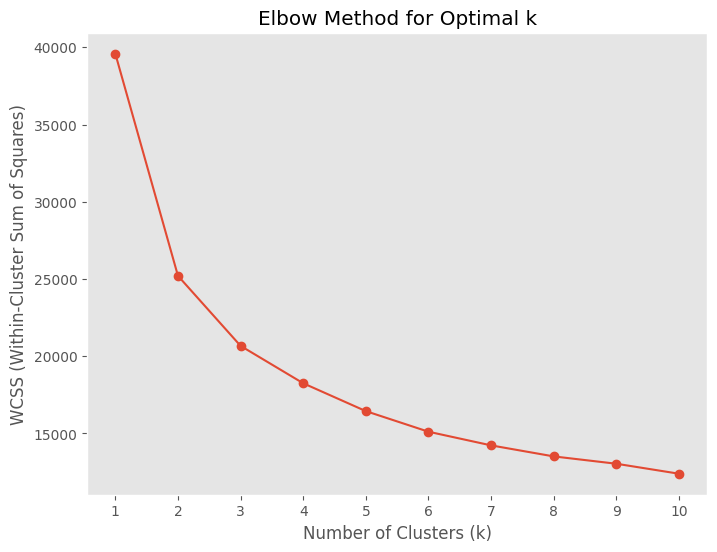

In [97]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Select Features for Clustering
features = normalized_spotify_dataset[["energy", "danceability", "valence", "tempo", "popularity", "acousticness", "loudness"]]

# Step 2: Compute WCSS for Different Values of k
wcss = []  # List to store Within-Cluster Sum of Squares (WCSS)
for k in range(1, 11):  # Test k values from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)

# Step 3: Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.xticks(range(1, 11))  # Ensure ticks align with k values
plt.grid()
plt.show()


 K-Means Clustering Using the Chosen k Value

In [98]:
# Step 1: Set the Optimal k Value (from the Elbow Method)
optimal_k = 5  # Replace this with the value determined from the elbow curve

# Step 2: Perform K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
normalized_spotify_dataset["cluster"] = kmeans.fit_predict(features)

# Step 3: Save the Clustered Dataset
normalized_spotify_dataset.to_csv("clustered_spotify_dataset.csv", index=False)
print("Clustered Spotify Dataset Saved.")

# Step 4: Display Clustered Data
print("Clustered Spotify Dataset (First 5 Rows):")
print(normalized_spotify_dataset.head())

# Optional: Display Cluster Centers for Analysis
print("Cluster Centers (Centroids):")
print(kmeans.cluster_centers_)


Clustered Spotify Dataset Saved.
Clustered Spotify Dataset (First 5 Rows):
   energy  danceability   valence     tempo  popularity  acousticness  \
0  0.4610      0.686294  0.718593  0.361245        0.73      0.032329   
1  0.1660      0.426396  0.268342  0.318397        0.55      0.927711   
2  0.3590      0.444670  0.120603  0.313643        0.57      0.210843   
3  0.0596      0.270051  0.143719  0.746758        0.71      0.908635   
4  0.4430      0.627411  0.167839  0.492863        0.82      0.470884   

   loudness                track_id  cluster  
0  0.791392  5SuOikwiRyPMVoIQDJUgSV        3  
1  0.597377  4qPNDBW1i3p13qLCt0Ki3A        1  
2  0.736123  1iJBSr7s7jYXzM8EGcbK5b        0  
3  0.573701  6lfxq3CG4xtTiEg7opyCyx        1  
4  0.737103  5vjLSffimiIP26QG5WcN2K        3  
Cluster Centers (Centroids):
[[0.77804738 0.48428882 0.24173927 0.5339942  0.32322012 0.06952978
  0.79487985]
 [0.25623963 0.43693163 0.23960435 0.45079184 0.31298037 0.82408316
  0.63573958]
 [0.5556419

Fetch Weather Data Using OpenWeather API

In [99]:
# Your OpenWeather API Key
API_KEY = "371ed997ca54c463d729680bd3742030"  # Replace with your actual API key

# Function to fetch weather data for a city
def fetch_weather_data(city):
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}&units=metric"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return {
            "city": city,
            "weather_code": data["weather"][0]["id"],  # Weather condition code
            "temperature": data["main"]["temp"],
            "humidity": data["main"]["humidity"],
            "pressure": data["main"]["pressure"],
            "cloudiness": data["clouds"]["all"],
            "wind_speed": data["wind"]["speed"],
            "precipitation": data.get("rain", {}).get("1h", 0) + data.get("snow", {}).get("1h", 0),  # Rain/Snow fallback
        }
    else:
        print(f"Failed to fetch weather data for {city}. Status Code: {response.status_code}")
        return None

# Fetch weather data for multiple cities
cities = ["New York", "Los Angeles", "Dhaka"]
weather_data = [fetch_weather_data(city) for city in cities if fetch_weather_data(city)]

# Check if weather data was successfully fetched
if weather_data:
    weather_df = pd.DataFrame(weather_data)
    print("Weather Data Fetched Successfully:")
    print(weather_df)
else:
    print("No valid weather data fetched. Please check your API key or city names.")


Weather Data Fetched Successfully:
          city  weather_code  temperature  humidity  pressure  cloudiness  \
0     New York           800       -10.27        62      1038           0   
1  Los Angeles           701        12.52        91      1019         100   
2        Dhaka           721        24.99        41      1012          39   

   wind_speed  precipitation  
0        5.81              0  
1        3.09              0  
2        2.57              0  


Process and Normalize Weather Data

In [100]:
from sklearn.preprocessing import StandardScaler

# Select weather features for normalization
weather_features = ["temperature", "humidity", "pressure", "cloudiness", "wind_speed", "precipitation"]

# Normalize weather data
scaler = StandardScaler()
weather_df[weather_features] = scaler.fit_transform(weather_df[weather_features])

# Display normalized weather data
print("Normalized Weather Data:")
print(weather_df)

# Check the structure of the DataFrame
print("Weather Data Columns:", weather_df.columns)


Normalized Weather Data:
          city  weather_code  temperature  humidity  pressure  cloudiness  \
0     New York           800    -1.325442 -0.130086  1.365519   -1.125884   
1  Los Angeles           701     0.235634  1.284595 -0.364138    1.304082   
2        Dhaka           721     1.089808 -1.154510 -1.001380   -0.178198   

   wind_speed  precipitation  
0    1.398337            0.0  
1   -0.516165            0.0  
2   -0.882172            0.0  
Weather Data Columns: Index(['city', 'weather_code', 'temperature', 'humidity', 'pressure',
       'cloudiness', 'wind_speed', 'precipitation'],
      dtype='object')


Map Weather Categories to Clusters

In [101]:
# Simplify weather categories
def simplify_weather_category(weather_code):
    if 200 <= weather_code < 300:
        return "stormy"
    elif 300 <= weather_code < 600:
        return "rainy"
    elif 600 <= weather_code < 700:
        return "snowy"
    elif weather_code == 800:
        return "clear"
    elif 801 <= weather_code <= 804:
        return "cloudy"
    elif 700 <= weather_code < 800:
        return "atmospheric"  # Covers mist, haze, smoke, etc.
    else:
        return "unknown"

# Map weather categories to music clusters
weather_to_music_map = {
    "clear": 0,          # Energetic and Cheerful
    "rainy": 1,          # Calm and Reflective
    "cloudy": 2,         # Bright and Uplifting
    "snowy": 3,          # Soft and Peaceful
    "stormy": 4,         # Intense and Powerful
    "atmospheric": 1     # Calm and Reflective
}

# Apply the mapping
weather_df["weather_category"] = weather_df["weather_code"].apply(simplify_weather_category)
weather_df["music_cluster"] = weather_df["weather_category"].apply(
    lambda category: weather_to_music_map.get(category, -1)  # Default to -1 if category is unknown
)

# Display the mapped weather data
print("Mapped Weather Data to Music Clusters:")
print(weather_df)


Mapped Weather Data to Music Clusters:
          city  weather_code  temperature  humidity  pressure  cloudiness  \
0     New York           800    -1.325442 -0.130086  1.365519   -1.125884   
1  Los Angeles           701     0.235634  1.284595 -0.364138    1.304082   
2        Dhaka           721     1.089808 -1.154510 -1.001380   -0.178198   

   wind_speed  precipitation weather_category  music_cluster  
0    1.398337            0.0            clear              0  
1   -0.516165            0.0      atmospheric              1  
2   -0.882172            0.0      atmospheric              1  


 Initial Recommendations

In [102]:
# Function to filter tracks by the mapped music cluster
def filter_tracks_by_cluster(cluster_id, dataset):
    return dataset[dataset["cluster"] == cluster_id]

# Function to generate initial recommendations
def generate_recommendations(weather_data, music_data, n_recommendations=5):
    # Get the music cluster mapped to the current weather
    music_cluster = weather_data["music_cluster"].iloc[0]  # Assuming a single weather entry for simplicity

    # Filter tracks from the music dataset
    filtered_tracks = filter_tracks_by_cluster(music_cluster, music_data)

    # Sort by popularity and select top recommendations
    recommended_tracks = filtered_tracks.sort_values(by="popularity", ascending=False).head(n_recommendations)

    return recommended_tracks

# Example usage:
current_weather = weather_df.iloc[[0]]  # Get the first row of the weather data as current weather
recommended_tracks = generate_recommendations(current_weather, normalized_spotify_dataset)

# Display the recommendations
print("Recommended Tracks Based on Current Weather:")
print(recommended_tracks[["track_id", "energy", "danceability", "valence", "popularity", "cluster"]])


Recommended Tracks Based on Current Weather:
                     track_id  energy  danceability   valence  popularity  \
81011  3USxtqRwSYz57Ewm6wWRMp   0.611      0.416244  0.090352        0.90   
81100  0WtM2NBVQNNJLh6scP13H8   0.737      0.327919  0.155779        0.90   
51277  4xkOaSrkexMciUUogZKVTS   0.847      0.556345  0.100503        0.86   
91800  0VF7YLIxSQKyNiFL3X6MmN   0.911      0.357360  0.237186        0.86   
3257   003vvx7Niy0yvhvHt4a68B   0.911      0.357360  0.237186        0.86   

       cluster  
81011        0  
81100        0  
51277        0  
91800        0  
3257         0  


Simulate or Collect User Feedback (simulated here)

In [103]:
# Simulate feedback for the recommended tracks
def simulate_feedback(recommended_tracks):
    # Simulate user feedback: 1 = liked, 0 = disliked
    # This can be replaced with actual user input in a real application
    recommended_tracks["feedback"] = [1, 0, 1, 1, 0]  # Example feedback
    return recommended_tracks

# Simulate feedback for the current recommendations
recommended_tracks = simulate_feedback(recommended_tracks)

# Display the recommendations with feedback
print("Recommended Tracks with Simulated Feedback:")
print(recommended_tracks[["track_id", "feedback"]])


Recommended Tracks with Simulated Feedback:
                     track_id  feedback
81011  3USxtqRwSYz57Ewm6wWRMp         1
81100  0WtM2NBVQNNJLh6scP13H8         0
51277  4xkOaSrkexMciUUogZKVTS         1
91800  0VF7YLIxSQKyNiFL3X6MmN         1
3257   003vvx7Niy0yvhvHt4a68B         0


Store Feedback in a Dataset(in a persistent storage)

In [104]:
# Updated Function to Store Feedback
def store_feedback(recommended_tracks, current_weather, feedback_data):
    new_feedback_entries = []

    # Loop through recommended tracks and combine with current weather data
    for index, row in recommended_tracks.iterrows():
        feedback_entry = {
            "temperature": current_weather["temperature"],
            "humidity": current_weather["humidity"],
            "pressure": current_weather["pressure"],
            "cloudiness": current_weather["cloudiness"],
            "wind_speed": current_weather["wind_speed"],
            "precipitation": current_weather["precipitation"],
            "weather_code": current_weather["weather_code"],  # Add weather_code
            "energy": row["energy"],
            "danceability": row["danceability"],
            "valence": row["valence"],
            "tempo": row["tempo"],
            "popularity": row["popularity"],
            "acousticness": row["acousticness"],
            "loudness": row["loudness"],
            "feedback": row["feedback"]  # User feedback (1 for liked, 0 for disliked)
        }
        new_feedback_entries.append(feedback_entry)

    # Convert new feedback entries to a DataFrame
    new_feedback_df = pd.DataFrame(new_feedback_entries)

    # Concatenate only if there are valid new feedback entries
    if not new_feedback_df.empty:
        feedback_data = pd.concat([feedback_data, new_feedback_df], ignore_index=True)

    return feedback_data


# Display the updated feedback dataset
print("Updated Feedback Dataset:")
print(feedback_data)


Updated Feedback Dataset:
  temperature humidity pressure cloudiness wind_speed precipitation  \
0          25       60     1012         50          5             0   
1          25       60     1012         50          5             0   

  weather_code  energy  danceability  valence  tempo  popularity  \
0          800     0.8           0.7      0.6  120.0        50.0   
1          800     0.6           0.5      0.4  100.0        40.0   

   acousticness  loudness  feedback  liked  
0           0.2      -5.0       1.0      1  
1           0.3      -6.0       0.0      0  


Train Linear and Logistic Regression Models
1. Linear Regression: Predict the suitability_score (a continuous value) for tracks based on their features and weather conditions.
2. Logistic Regression: Predict the probability of a user liking a track (like_probability) as a binary classification problem (liked: 1, disliked: 0).

In [105]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score

# Prepare features and target for Linear Regression
X_linear = feedback_data[[
    "temperature", "humidity", "pressure", "cloudiness", "wind_speed", "precipitation",
    "energy", "danceability", "valence", "tempo", "popularity", "acousticness", "loudness", "weather_code"
]]
y_linear = feedback_data["feedback"]  # Using feedback as suitability_score

# Train-Test Split for Linear Regression
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(X_linear, y_linear, test_size=0.2, random_state=42)

# Train Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train_linear, y_train_linear)

# Evaluate Linear Regression Model
y_pred_linear = linear_model.predict(X_test_linear)
mse = mean_squared_error(y_test_linear, y_pred_linear)
print(f"Linear Regression Mean Squared Error: {mse:.2f}")

# Binarize the feedback column for Logistic Regression
feedback_data["liked"] = (feedback_data["feedback"] > 0.5).astype(int)

# Prepare features and target for Logistic Regression
y_logistic = feedback_data["liked"]

# Train-Test Split for Logistic Regression
X_train_logistic, X_test_logistic, y_train_logistic, y_test_logistic = train_test_split(X_linear, y_logistic, test_size=0.2, random_state=42)

# Train Logistic Regression Model
logistic_model = LogisticRegression()
logistic_model.fit(X_train_logistic, y_train_logistic)

# Evaluate Logistic Regression Model
y_pred_logistic = logistic_model.predict(X_test_logistic)
accuracy = accuracy_score(y_test_logistic, y_pred_logistic)
precision = precision_score(y_test_logistic, y_pred_logistic)
recall = recall_score(y_test_logistic, y_pred_logistic)
f1 = f1_score(y_test_logistic, y_pred_logistic)

print(f"Logistic Regression Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")


Linear Regression Mean Squared Error: 1.00


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

Integrate the Models into the Recommendation System

1. Use the Linear Regression model to predict a suitability score for all tracks in a given cluster.
2. Use the Logistic Regression model to predict the probability of a track being liked.
3. Combine these predictions to rank tracks for recommendation.


In [107]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
dataset_imputed = imputer.fit_transform(dataset)
import numpy as np

def recommend_tracks(current_weather, dataset, linear_model, logistic_model, top_n=5):
    """
    Recommend tracks based on the current weather and trained models.
    """
    # Ensure the dataset has the required columns in the correct order
    required_features = [
        "temperature", "humidity", "pressure", "cloudiness", "wind_speed", "precipitation",
        "energy", "danceability", "valence", "tempo", "popularity", "acousticness", "loudness", "weather_code"
    ]

    # Align dataset columns with required features
    dataset = dataset.reindex(columns=required_features)

    # Handle missing values by filling them with the column mean
    dataset = dataset.fillna(dataset.mean(numeric_only=True))

    # Predict suitability scores (Linear Regression)
    suitability_scores = linear_model.predict(dataset_imputed)

    # Predict like probabilities (Logistic Regression)
    like_probabilities = logistic_model.predict_proba(dataset)[:, 1]

    # Add scores and probabilities to the dataset
    dataset["suitability_score"] = suitability_scores
    dataset["like_probability"] = like_probabilities

    # Rank tracks based on combined scores
    dataset["combined_score"] = 0.7 * dataset["suitability_score"] + 0.3 * dataset["like_probability"]
    ranked_tracks = dataset.sort_values(by="combined_score", ascending=False).head(top_n)

    return ranked_tracks

# Call the updated recommendation function
recommended_tracks = recommend_tracks(current_weather, normalized_spotify_dataset, linear_model, logistic_model, top_n=5)

# Display the recommended tracks
print("Recommended Tracks:")
print(recommended_tracks)


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Example Usage: user UI

In [108]:
# Example current weather data (could be fetched from OpenWeather API)
current_weather = {
    "temperature": 25,  # Degrees Celsius
    "humidity": 60,     # %
    "pressure": 1012,   # hPa
    "cloudiness": 50,   # %
    "wind_speed": 5,    # m/s
    "precipitation": 0,  # mm
    "weather_code": "300"
}

# Call the recommendation function
recommended_tracks = recommend_tracks(current_weather, normalized_spotify_dataset, linear_model, logistic_model, top_n=5)

# Display the recommended tracks
print("Recommended Tracks:")
print(recommended_tracks)


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values